In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB
import pickle
from sklearn.externals import joblib

In [15]:
import pandas as pd
import os 
print(os.getcwd())
data = pd.read_csv('../stats.txt', delim_whitespace=True)
data = data.sample(frac=1).reset_index(drop=True)
modelfile = 'final.sav'
projectdir = "/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/"


array = data.values

print(data.head())
print(data.shape)
data.columns=['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13','col14','col15','col16','col17']
z = data['col2'].str.split('-')
print(z.head())
data['col13']=data['col13'].eq("enable").mul(1)
data['col14']=data['col14'].eq("enable").mul(1)
data['col15']=data['col15'].eq("enable").mul(1)
data['col16']=data['col16'].eq("enable").mul(1)

/home/dsinghvi/sem8/parallel/project/mnt/progress/active
   S3D-IO    50-50-100-2-2-4-1  526.27  0.03  0.06    66.03   0.15   2.31  \
0  S3D-IO  200-200-400-2-2-4-1  740.09  1.91  2.64   522.31   5.72  11.22   
1  S3D-IO  100-200-400-2-4-4-1  994.52  0.95  0.98   639.45   2.86   4.58   
2  S3D-IO   50-100-100-2-2-4-1  439.37  0.06  0.14   131.78   0.30   2.32   
3  S3D-IO  400-400-400-4-4-4-1  941.22  7.63  8.30  1037.75  22.89  22.58   
4  S3D-IO  200-400-400-2-2-4-1  598.70  3.81  6.53   191.67  11.44  61.14   

   0.05  0.01    196608  12   enable enable.1 enable.2  disable  478150656  
0  0.04  0.10    327680  19  disable  disable   enable  disable  493879296  
1  0.05  0.05  25952256   4  disable   enable   enable   enable  189792256  
2  0.06  0.02    196608   4  disable  disable   enable   enable    5242880  
3  0.16  0.39    262144   6  disable  disable  disable  disable  530579456  
4  0.06  0.19    655360  48  disable  disable  disable  disable  218103808  
(1135, 17)
0    [2

In [16]:
##### FEATURES for our model(some could be specific to the benchmark)

X_temp = pd.DataFrame() #creates a new dataframe that's empty
X = pd.DataFrame(z.tolist())
X = X.drop(6, 1)

#MPI AND LUSTURE HINTS ADDED AS FEATURES
X_temp['cb1']=data['col11']
X_temp['cb2']=data['col12']
#X['cb3']=data['col13']
#X['cb4']=data['col14']
#X['cb5']=data['col15']
#X['cb6']=data['col16']
X_temp['cb7']=data['col17']

X =pd.concat([X, X_temp], axis=1)

#RATIO added as feature to give size of box each process needs to take(specific to S3D-IO)
X['ratio1'] = X.iloc[:,0].astype(int)/(X.iloc[:,3].astype(int)*100)
X['ratio2'] = X.iloc[:,1].astype(int)/(X.iloc[:,4].astype(int)*100)
X['ratio3'] = X.iloc[:,2].astype(int)/(X.iloc[:,5].astype(int)*100)

###NORMALIZING 
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X.values)
X = pd.DataFrame(X_scaled)
print(type(X))
print(X.head())
i=0

for _ in X.columns:
    if(i == 0):
        continue
    X.iloc[:,i].astype(int)
    print(i)
    i=i+1 

#pd.options.display.max_rows=  1500
#print(X.iloc[:,0])



<class 'pandas.core.frame.DataFrame'>
         0         1         2    3    4         5         6         7   \
0  0.428571  0.428571  0.466667  0.0  0.0  0.333333  0.000274  0.039175   
1  0.142857  0.428571  0.466667  0.0  1.0  0.333333  0.021674  0.008247   
2  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000164  0.008247   
3  1.000000  1.000000  0.466667  1.0  1.0  0.333333  0.000219  0.012371   
4  0.428571  1.000000  0.466667  0.0  0.0  0.333333  0.000547  0.098969   

         8         9         10        11  
0  0.461237  0.428571  0.428571  0.428571  
1  0.176644  0.142857  0.142857  0.428571  
2  0.003925  0.000000  0.142857  0.000000  
3  0.495584  0.428571  0.428571  0.428571  
4  0.203140  0.428571  1.000000  0.428571  


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
Y = data['col6'] ### WRITE BANDWIDTH
Y=Y.values
Y = Y*100
Y = Y.astype(int)


#### SPLITTING INTO TEST -TRAIN DATASET
msk = np.random.rand(len(X)) < 0.8
train_X = X[msk]
test_X = X[~msk]
train_Y = Y[msk]
test_Y = Y[~msk]
print(type(train_X))

y = train_Y
X = train_X

print(X[0:5])
print(type(X))

print(y.shape, X.shape)
print(y[0:5])



<class 'pandas.core.frame.DataFrame'>
         0         1         2    3    4         5         6         7   \
0  0.428571  0.428571  0.466667  0.0  0.0  0.333333  0.000274  0.039175   
1  0.142857  0.428571  0.466667  0.0  1.0  0.333333  0.021674  0.008247   
2  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000164  0.008247   
3  1.000000  1.000000  0.466667  1.0  1.0  0.333333  0.000219  0.012371   
4  0.428571  1.000000  0.466667  0.0  0.0  0.333333  0.000547  0.098969   

         8         9         10        11  
0  0.461237  0.428571  0.428571  0.428571  
1  0.176644  0.142857  0.142857  0.428571  
2  0.003925  0.000000  0.142857  0.000000  
3  0.495584  0.428571  0.428571  0.428571  
4  0.203140  0.428571  1.000000  0.428571  
<class 'pandas.core.frame.DataFrame'>
(916,) (916, 12)
[ 52230  63945  13178 103775  19167]


In [18]:
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)
X_transformed

<916x75 sparse matrix of type '<class 'numpy.float64'>'
	with 9160 stored elements in Compressed Sparse Row format>

In [19]:
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)


In [20]:
nb = BernoulliNB()
nb.fit(X_transformed, y)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [21]:
trees = ExtraTreesClassifier(max_depth=1000, n_estimators=300, random_state=0)
trees.fit(X, y)



ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1000, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
print(test_X.head(1))
print(test_X.shape)
trees.predict(test_X.head(1))

    0    1         2    3    4         5         6         7        8    9   \
5  1.0  1.0  0.466667  0.0  1.0  0.333333  0.006458  0.136082  0.39156  1.0   

         10        11  
5  0.428571  0.428571  
(219, 12)


array([69933])

In [23]:
predicted = trees.predict(test_X)
#print(test_Y)
from sklearn.metrics import r2_score
r2_score(test_Y,predicted)

0.7817485034897914

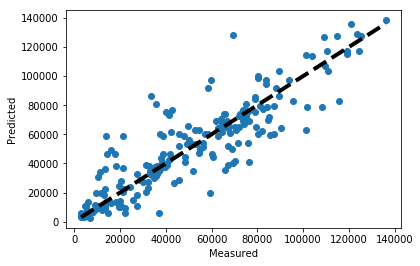

In [24]:
fig, ax = plt.subplots()
ax.scatter(test_Y, predicted)
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
# save the model to disk

modelfile = 'final.sav'
pickle.dump(trees, open(modelfile, 'wb'))
scaler_filename = "scaler.save"
joblib.dump(min_max_scaler, scaler_filename) 


In [ ]:
import json
with open(projectdir+'confex.json') as f:
    data = json.load(f)

romio_ds_read = data["mpi"]["romio_ds_read"]
romio_ds_write = data["mpi"]["romio_ds_write"]
romio_cb_read = data["mpi"]["romio_cb_read"]
romio_cb_write = data["mpi"]["romio_cb_write"]
cb_buffer_size = data["mpi"]["cb_buffer_size"]
stripe_size = data["lfs"]["setstripe"]["size"]
stripe_count = data["lfs"]["setstripe"]["count"]

col_names =  ['cb1', 'cb2', 'cb5','cb6','cb7']
cb_df  = pd.DataFrame(columns = col_names)
cb_df.loc[len(cb_df)] = [romio_ds_read,romio_ds_write,stripe_size, stripe_count, cb_buffer_size]


scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 
norm_df = scaler.transform( cb_df )
temp = pd.DataFrame(norm_df)




col_names =  ['0','1', '2','3','4','5','6','7','8','9','10']
my_df = pd.DataFrame(columns=col_names)
my_df.loc[len(my_df)] = [100,100,100,2,2,4]
x = pd.concat([my_df,temp], axis=1)


print(trees.predict(x))

In [ ]:
print(predicted)

In [ ]:
x


In [ ]:
test_X.head(1)

In [ ]:
trees.predict(test_X.head(1))